# Reproducible Research - Assignment Week 2

## Loading and preprocessing the data

We load the necessary packages here and the Activity dataset provided. 
We convert the date column which is encoded as string into a Date column

In [19]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(knitr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggthemes))

In [20]:
setwd('/Users/rohitpittu/R Projects/DataScience/Reproducible Research/RepData_PeerAssessment1')
activity <-read.csv("activity.csv",stringsAsFactors = FALSE)
str(activity)
activity$date = as.Date(activity$date,"%Y-%m-%d")

'data.frame':	17568 obs. of  3 variables:
 $ steps   : int  NA NA NA NA NA NA NA NA NA NA ...
 $ date    : chr  "2012-10-01" "2012-10-01" "2012-10-01" "2012-10-01" ...
 $ interval: int  0 5 10 15 20 25 30 35 40 45 ...


## Total number of steps per day
We are required to plot a histogram of total number of steps taken each day during the measured period. We can ignore the missing NA values for this step

### Histogram Plot

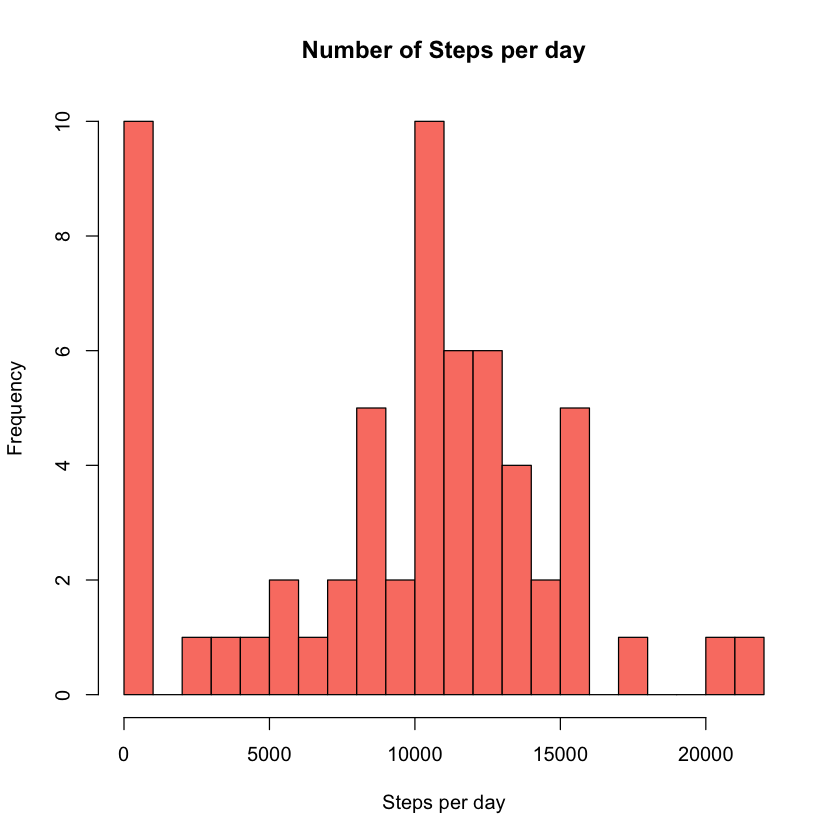

In [7]:
activity.day.steps <- aggregate(activity$steps, 
                                by = list(activity$date),
                                FUN = "sum",na.rm = TRUE)

h1 <- hist(activity.day.steps[,2],xlab="Steps per day",
           main ="Number of Steps per day",
           col ="salmon",breaks =20)

### Mean and Median steps per day

In [8]:
mean.total.steps <- round(mean(activity.day.steps[,2]),2)
median.total.steps <- round(median(activity.day.steps[,2]),2)
tab <- data.frame(Mean = mean.total.steps,Median = median.total.steps)
kable(tab)



|    Mean| Median|
|-------:|------:|
| 9354.23|  10395|

## Average daily Activity Pattern

### Time Series Plot

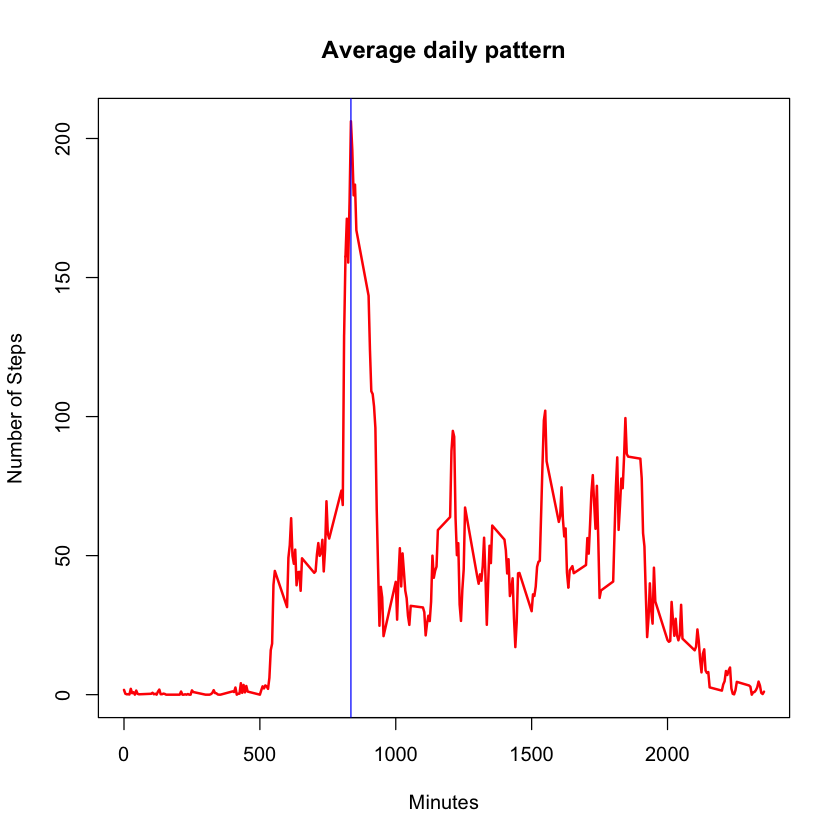

In [21]:
activity.time.steps <- aggregate(activity$steps, by = list(activity$interval),FUN = "mean",na.rm = TRUE)
names(activity.time.steps) <- c("Interval","AvgSteps")
Max.5 <- activity.time.steps[activity.time.steps$AvgSteps == max(activity.time.steps$AvgSteps),1 ]

plot(x = activity.time.steps$Interval,y = activity.time.steps$AvgSteps,
     type = 'l',main = "Average daily pattern",
     xlab = "Minutes",ylab = "Number of Steps",col = "red",lwd=2 )
abline(v = Max.5,col = "blue",lwd =1)


## Imputing missing values
**Impute Strategy** is to replace NA values for any 5 minute interval with the average value for that 5 minute interval across all days

### Creating a data set after imputing data

In [22]:
impute <- function(v){
    
    if(is.na(v['steps'])){
        steps = activity.time.steps[activity.time.steps$Interval==as.numeric(v['interval']),2]
    }
    else{
        steps = v['steps']
    } 
    return(steps)
}

clean.steps = as.vector(NULL)

clean.steps <- apply(X = activity[,c(1,3)],1,FUN = impute)

activity.clean <-cbind(activity,clean.steps)

## Comparison of histograms after imputing data

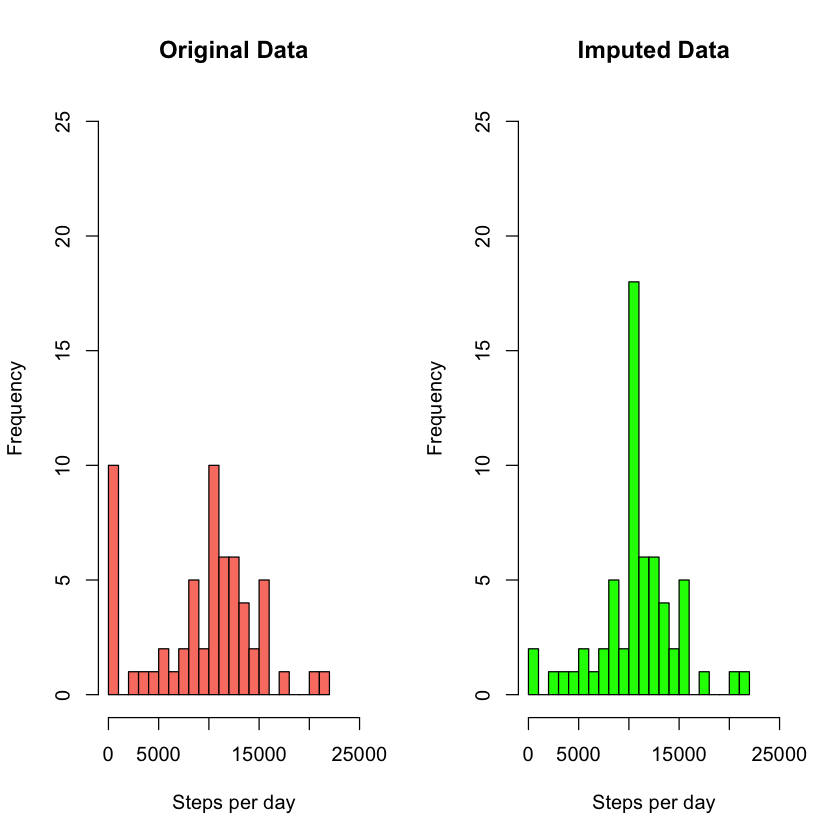

In [23]:
activity.day.clean <- aggregate(activity.clean$clean.steps,
                                     by = list(activity.clean$date),
                                     FUN = "sum")

par(mfrow=c(1,2))
h1 <- hist(activity.day.steps[,2],
           xlab="Steps per day",main ="Original Data",
           col ="salmon",breaks =20,xlim = c(0,25000),ylim = c(0,25))

h2 <- hist(activity.day.clean[,2],
           xlab="Steps per day",main ="Imputed Data",
           col ="green",breaks =20,xlim = c(0,25000),ylim = c(0,25))

### Mean and Median Steps per day: Original data vs imputed data

In [24]:
mean.total.cleansteps <- round(mean(activity.day.clean[,2]),2)
median.total.cleansteps <- round(median(activity.day.clean[,2]),2)

tabclean <- rbind(tab,c(mean.total.cleansteps,median.total.cleansteps))
row.names(tabclean)<-c("Original Data","Imputed Data")
kable(tabclean)



|              |     Mean|   Median|
|:-------------|--------:|--------:|
|Original Data |  9354.23| 10395.00|
|Imputed Data  | 10766.19| 10766.19|

## Weekday vs Weekend Activity Pattern

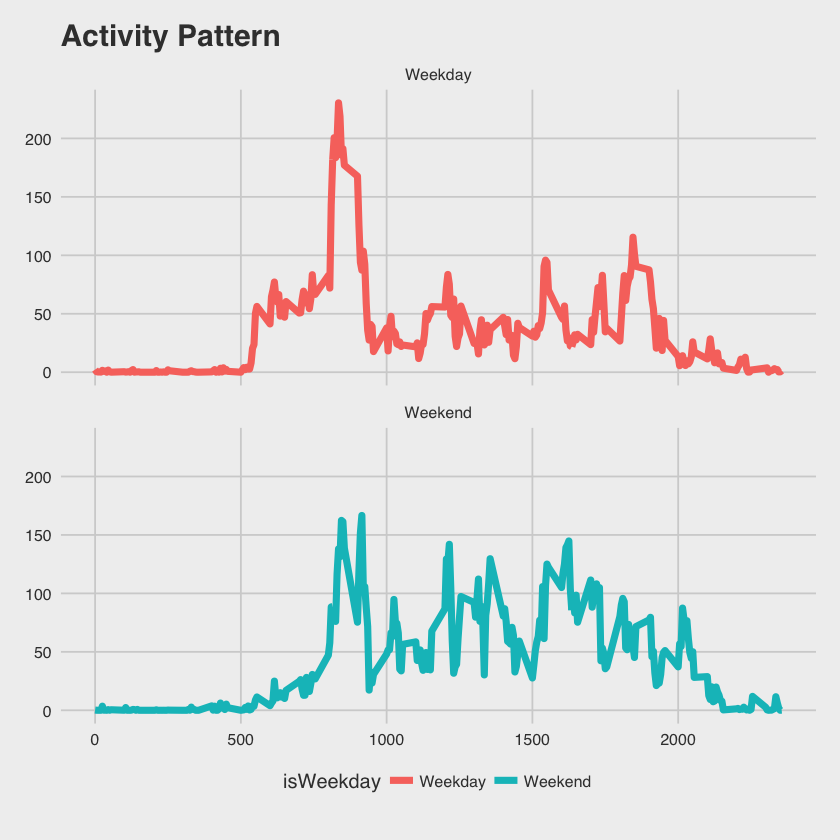

In [26]:
activity.time.clean <- as.tbl(activity.clean) %>%
    mutate(isWeekday = ifelse(weekdays(date) %in% c("Saturday","Sunday"),"Weekend","Weekday"))%>%
    mutate(isWeekday=as.factor(isWeekday))%>%
    group_by(isWeekday,interval)%>%
    summarize(AvgSteps = mean(clean.steps))%>%
    select(interval,AvgSteps,isWeekday)

    
g <- ggplot(activity.time.clean) +
    geom_line(aes(x= interval, y=AvgSteps, col = isWeekday),size =2) +
    labs( x = "Time Interval(in mins)", y="Average Steps",title ="Activity Pattern") +
    facet_wrap(facets = ~ isWeekday,nrow=2)+
    theme_fivethirtyeight()

print(g)